# Data Exploration of Chicago Crimes Data

I performed a brief exploratory analysis of the cleaned dataset. I looked at a few different columns in the cleaned dataset to get an initial idea of whether or not they would be helpful features for predicting whether there will be an arrest for a new crime. The columns I believe will be most helpful are the community area, type of crime, and the year the crime occurred.

However, I plan to include all of these variables in my initial modeling attempts to see if my hypothesis are true.

I also explored the raw counts of crimes and homicides, along with the per capita counts, to see if there were any interesting trends. One of the most interesting trends I want to point out is how the raw counts of crimes and homicides can be deceiving. Looking specifically at the plots showing the Community Areas with the Least and Most Crimes with both the raw counts and crimes per capita in the [All Crimes and Homicides by Community Area](#comm_areas) section, we can see that Fuller Park is among the community areas with the least amount of crime, but when looking at the crimes per capita (the raw counts divided by the 2010 Census population sizes), Fuller Park has more crime per capita than all the  community areas in Chicago.  
  
Another thing I found interesting was the low arrest rate. The arrest rate for all crimes in the city of Chicago was only 24.96%, which shocked me. The arrest rate for homicides was higher at 37.18% but still lower than I thought it would be (though that's probably because I've been watching too many unrealistic cop shows).

## Table of Contents
* [Description of Columns](#col_description)
* [Reading in Cleaned Dataset](#read_data)
* [Retrieving Region and Community Area Populations for Normalizing Counts](#populations)
* [Plotting Function](#plot_func)
* Arrest Rates
    - [By Region](#arrests_region)
    - [By Community Area](#arrests_comm_areas)
    - [By Type of Crime](#arrests_type)
    - [By Year](#arrests_year)
    - [By Month](#arrests_month)
    - [By Domestic vs Non-Domestic](#arrests_domestic)  
    - [By Season](#arrests_season)
    - [By Time of Day](#arrests_time)  
    - [By Day of Week](#arrests_day)  
* All Crimes and Homicides
    - [By Region](#region)
    - [By Community Area](#comm_areas)
    - [By Year](#year)  
    - [By Time of Day](#time)  
    - [By Season](#season)  

<a id="col_description">

## Description of Columns
The original column descriptions from the City of Chicago 
[website](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2).

| Column Name  | Column Description |  
| :-:    | :-- |  
| Date                 | Date when the incident occurred (sometimes an estimate) |
| Primary Type         | The primary description of the IUCR code |
| Arrest               | Indicates whether an arrest was made |
| Domestic             | Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence act |
| Year                 | The year the incident occurred |
| Location             | The location where the incident occurred in a format that allows for creation of maps and other geographic operations on this data portal. This location is shifted from the actual location for partial redaction but falls on the same block |
| Location Description | Description of the location where the incident occurred |
| Community Area       | Indicates the community area where the incident occurred (Chicago has 77 community areas) |
| Region               | Indicates the region of Chicago where the incident occurred |
| 2010 Population      | Indicates the community area where the incident occurred (Chicago has 77 community areas) |
| Month                | Indicates the month the incident occurred |
| Day of Week          | Indicates the day of the week the incident occurred |
| Time of Day          | Indicates the time of day where the incident occurred (Morning, Afternoon, Evening, Night) |
| Season               | Indicates the season when the incident occurred (Spring, Summer, Fall, Winter)  |

<a id="read_data">

## Reading in the Cleaned Dataset

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

In [2]:
crimes = pd.read_csv('Data/crimes_cleaned.csv', parse_dates=['Date'])
print("Number of Crimes from {} to {}: {:,d}".format(crimes.Date.min(),crimes.Date.max(),crimes.shape[0]))

Number of Crimes from 2010-01-01 00:00:00 to 2019-11-25 00:00:00: 2,924,694


In [3]:
#sorting 
crimes.head()

,Date,Primary Type,Arrest,Domestic,Year,Location,Location Description,Community Area,Region,2010 Population,Month,Day of Week,Time of Day,Season
0,2019-04-10 16:37:00,Sex Offense,0,False,2019,"(41.708589, -87.612583094)",School,Roseland,Far Southeast Side,44619.0,4,Wednesday,Afternoon,Spring
1,2019-04-19 13:57:00,Offense Involving Children,0,True,2019,"(41.884865037, -87.755230327)",Residence,Austin,West Side,98514.0,4,Friday,Afternoon,Spring
2,2019-04-12 16:08:00,Offense Involving Children,0,True,2019,"(41.940297617, -87.732066473)",Residence,Irving Park,Northwest Side,53359.0,4,Friday,Afternoon,Spring
3,2019-04-25 17:20:00,Battery,0,True,2019,"(41.697609261, -87.613507612)",Residence,Roseland,Far Southeast Side,44619.0,4,Thursday,Evening,Spring
4,2019-05-13 17:26:00,Assault,0,False,2019,"(41.729973132, -87.653166753)",Street,Washington Heights,Far Southwest Side,26493.0,5,Monday,Evening,Spring


<a id="plot_func">

<a id="populations">

## Retrieving Region and Community Area Populations for Normalizing Counts

In [4]:
comm_area_pop = crimes.groupby(['Community Area', 'Region'])['2010 Population'].max().reset_index()
comm_area_pop.head()

,Community Area,Region,2010 Population
0,Albany Park,Far North Side,51542.0
1,Archer Heights,Southwest Side,13393.0
2,Armour Square,South Side,13391.0
3,Ashburn,Far Southwest Side,41081.0
4,Auburn Gresham,Far Southwest Side,48743.0


In [5]:
region_pop = comm_area_pop.groupby(['Region'])['2010 Population'].sum().reset_index()
region_pop.head()

,Region,2010 Population
0,Central,131157.0
1,Far North Side,453704.0
2,Far Southeast Side,224793.0
3,Far Southwest Side,177988.0
4,North Side,303208.0


## Plotting Function
To avoid needlessly repeating code.

In [6]:
#setting the default background for the plots
sns.set(style="whitegrid")

#defining the plotting function
def plot_crime(data, x_col, y_col, title, fig_size=(20,10), y_format='{x:,.0f}'):
    """
        function to create and show a bar chart using the provided data and columns
        
        inputs:
            data     : pandas dataframe containing the data to display
            x_col    : string containing the column name for the X variable (must be a column in data)
            y_col    : string containing the column name for the Y variable (must be a column in data)
            title    : string containing the title for the bar chart
            fig_size : (optional) 2 dimensional tuple containing the size of the bar chart
            y_format : (optional) string containing the way to format the y axis ticks
        
        output:
            None
    """
    fig, ax = plt.subplots(figsize=fig_size)
    ax = sns.barplot(data=data, x=x_col, y=y_col)
    plt.title(title, fontsize=20)
    plt.xlabel(None)
    plt.ylabel(y_col, fontsize=15)
    ax.yaxis.set_major_formatter(StrMethodFormatter(y_format))
    plt.show()

<a id="arrests_region">

## Arrest Rates by Region
The low percentage of arrests for crimes in Chicago was shocking to me. I expected it to be at least 50%. Fortunately, the arrest rate for homicides is higher but still much lower than I expected.  
  
Because there isn't as much of a difference between between the arrest rates between regions compared to the community areas, I believe this won't be as helpful of a feature in predicting the arrest rate for new crimes. 

In [7]:
print("Chicago Arrest Rate: {:.2f}%".format(100*crimes.Arrest.mean()))

Chicago Arrest Rate: 24.96%


In [8]:
#grouping all crimes by region
region_arrests = crimes.groupby(['Region'])['Arrest'].mean().sort_values(ascending=False).reset_index()
region_arrests.columns = ["Region", "Arrest Rate"]

#converting Arrest Rate column to percentage
region_arrests['Arrest Rate'] *= 100

region_arrests

,Region,Arrest Rate
0,West Side,31.568886
1,Southwest Side,26.567793
2,Far Southeast Side,25.198468
3,South Side,23.272455
4,Far Southwest Side,22.971168
5,Central,21.939460
6,Far North Side,20.438095
7,Northwest Side,19.790267
8,North Side,15.496761


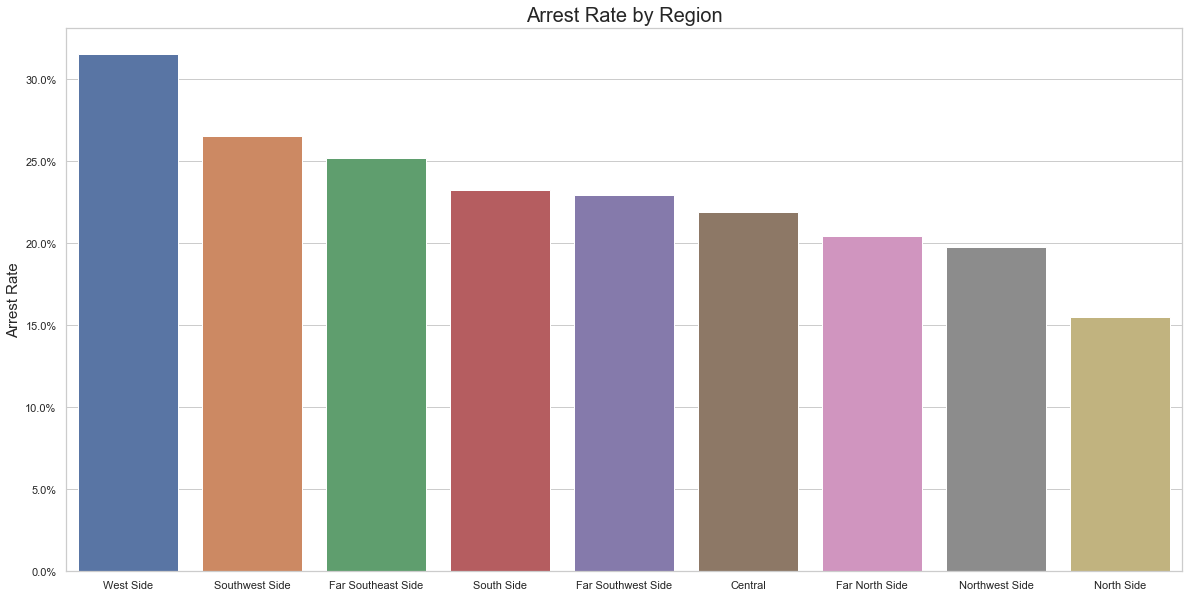

In [9]:
#plotting the arrest rates by region
plot_crime(region_arrests, x_col="Region", y_col="Arrest Rate", title="Arrest Rate by Region", y_format='{x:,.1f}%')

In [10]:
print("Chicago Homicide Arrest Rate: {:.2f}%".format(100*crimes[crimes['Primary Type'] == 'Homicide'].Arrest.mean()))

Chicago Homicide Arrest Rate: 37.18%


In [11]:
#grouping all crimes by region
region_hom_arrests = crimes[crimes['Primary Type'] == 'Homicide'].groupby(['Region'])['Arrest'].mean().sort_values(ascending=False).reset_index()
region_hom_arrests.columns = ["Region", "Arrest Rate"]

#converting Arrest Rate column to percentage
region_hom_arrests['Arrest Rate'] *= 100

region_hom_arrests

,Region,Arrest Rate
0,Central,71.875000
1,Far North Side,53.051643
2,Northwest Side,51.923077
3,North Side,51.111111
4,South Side,40.679012
5,Southwest Side,34.845735
6,Far Southeast Side,34.685230
7,West Side,34.123077
8,Far Southwest Side,31.007752


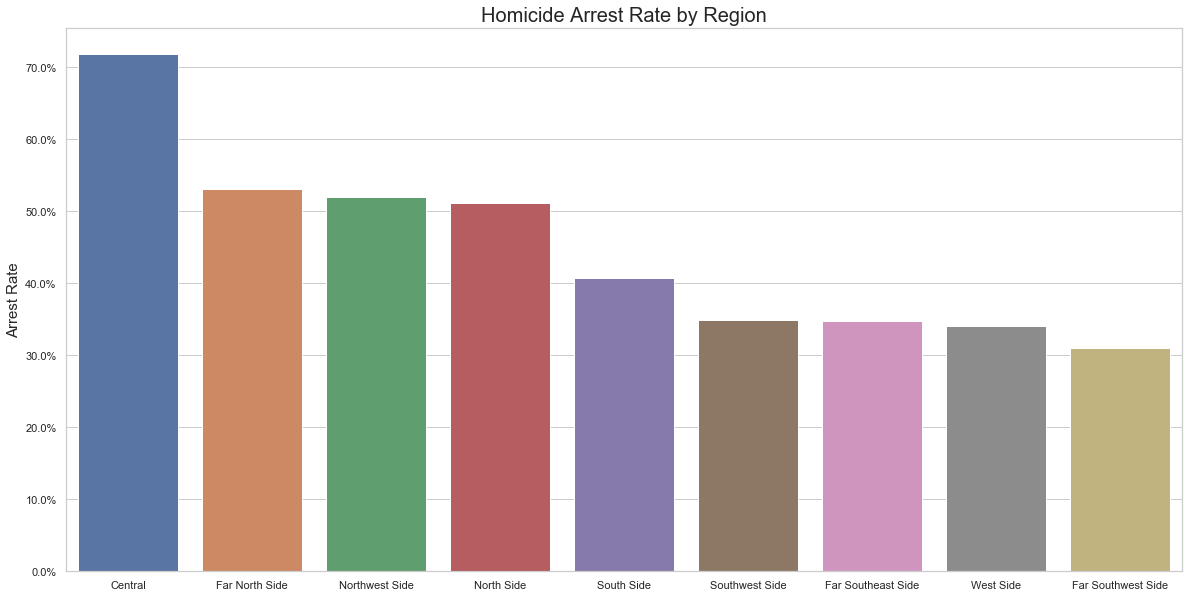

In [12]:
#plotting the homicide arrest rates by region
plot_crime(region_hom_arrests, x_col="Region", y_col="Arrest Rate", title="Homicide Arrest Rate by Region", y_format='{x:,.1f}%')

<a id="arrests_comm_areas">

## Arrest Rates by Community Areas
The Community Areas with the highest Homicide Arrest Rates have the lowest amount of homicides, which makes sense.  
  
Because of the noticeable differences between the top and bottom arrest rates, I believe the type of crime will be a valuable feature in predicting the arrest rate for new crimes. 

In [13]:
#grouping all crimes by community area
comm_area_arrests = crimes.groupby(['Community Area'])['Arrest'].mean().sort_values(ascending=False).reset_index()
comm_area_arrests.columns = ["Community Area", "Arrest Rate"]

#converting Arrest Rate column to percentage
comm_area_arrests['Arrest Rate'] *= 100

comm_area_arrests.head(10)

,Community Area,Arrest Rate
0,West Garfield Park,45.154830
1,Humboldt Park,37.480757
2,North Lawndale,37.158435
3,East Garfield Park,36.162805
4,Austin,35.693862
5,New City,30.830999
6,Fuller Park,30.638341
7,West Englewood,29.368806
8,Englewood,28.287071
9,Woodlawn,28.067045


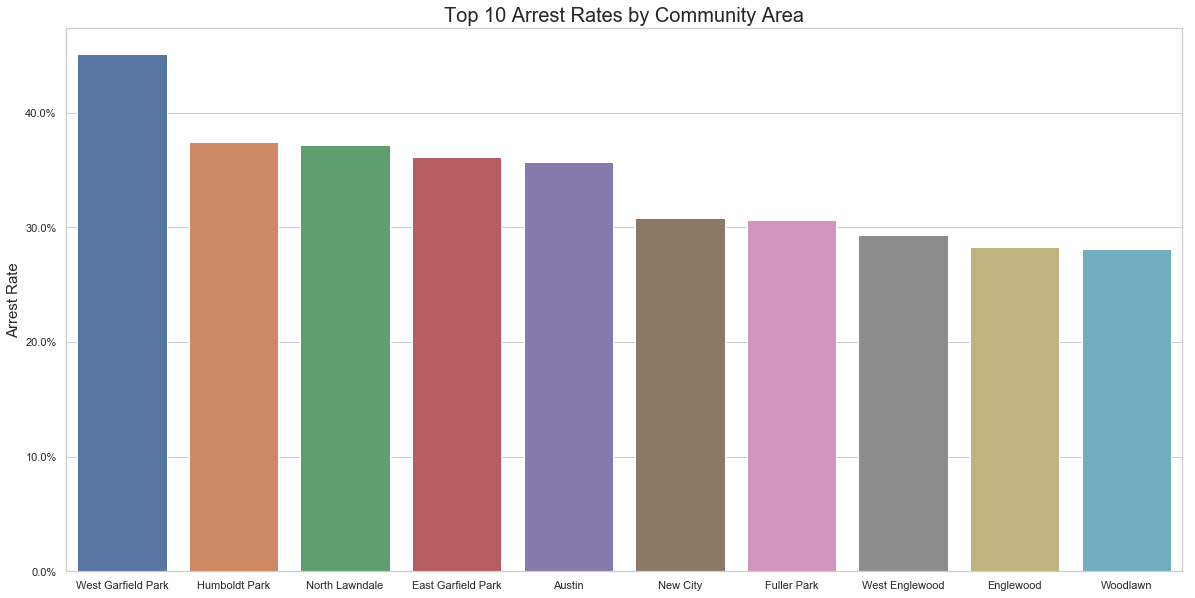

In [14]:
#plotting the arrest rates by community area
plot_crime(comm_area_arrests.iloc[:10,:], x_col="Community Area", y_col="Arrest Rate", title="Top 10 Arrest Rates by Community Area",
           y_format='{x:,.1f}%')

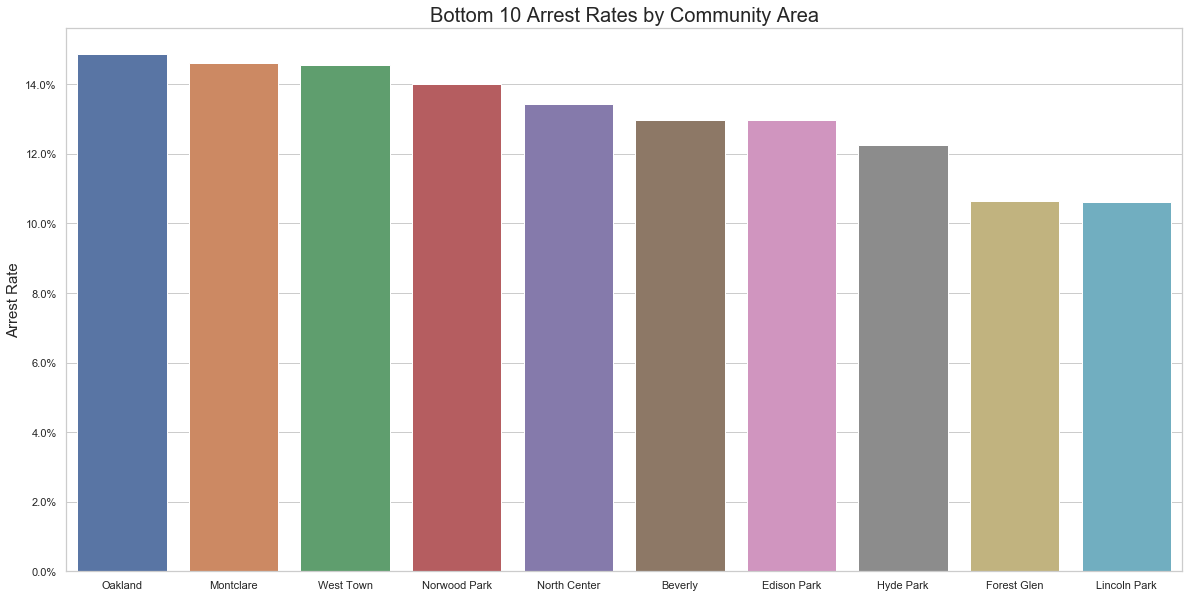

In [15]:
#plotting the arrest rates by community area
plot_crime(comm_area_arrests.iloc[-10:,:], x_col="Community Area", y_col="Arrest Rate", title="Bottom 10 Arrest Rates by Community Area",
           y_format='{x:,.1f}%')

In [16]:
#grouping all crimes by community area
comm_area_hom_arrests = crimes[crimes['Primary Type'] == 'Homicide'].groupby(['Community Area'])['Arrest'].mean().sort_values(ascending=False).reset_index()
comm_area_hom_arrests.columns = ["Community Area", "Arrest Rate"]

#converting Arrest Rate column to percentage
comm_area_hom_arrests['Arrest Rate'] *= 100

comm_area_hom_arrests.head(10)

,Community Area,Arrest Rate
0,Mount Greenwood,100.000000
1,North Center,100.000000
2,North Park,100.000000
3,Forest Glen,100.000000
4,Dunning,86.666667
5,Clearing,85.714286
6,Norwood Park,75.000000
7,Loop,75.000000
8,O'Hare,75.000000
9,Near South Side,75.000000


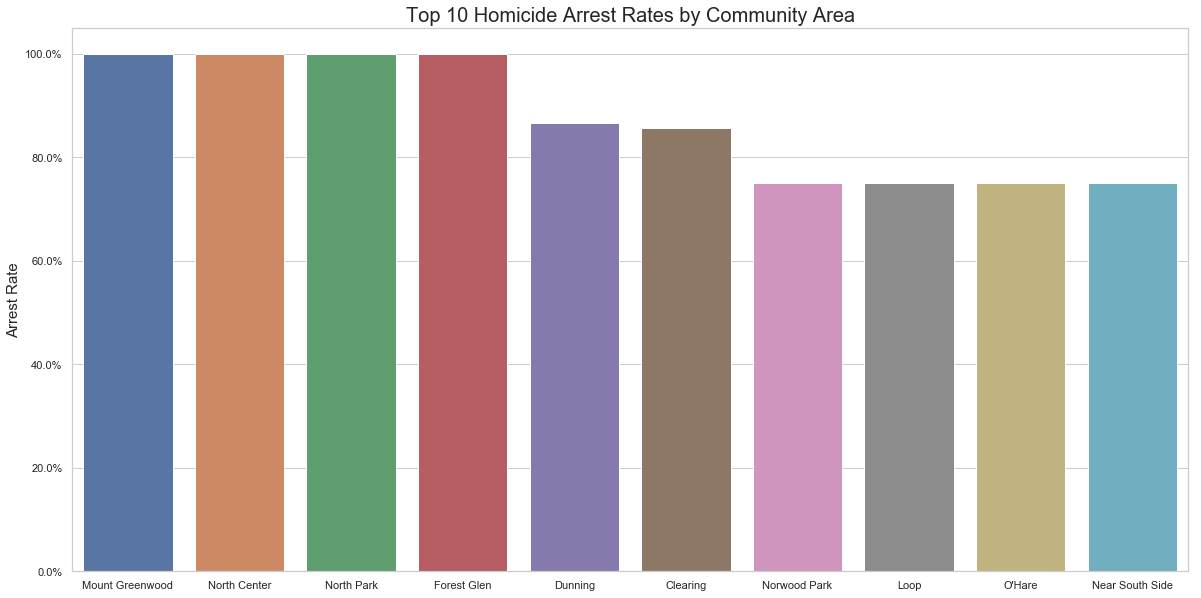

In [17]:
#plotting the homicide arrest rates by community area
plot_crime(comm_area_hom_arrests.iloc[:10,:], x_col="Community Area", y_col="Arrest Rate", 
           title="Top 10 Homicide Arrest Rates by Community Area", y_format='{x:,.1f}%')

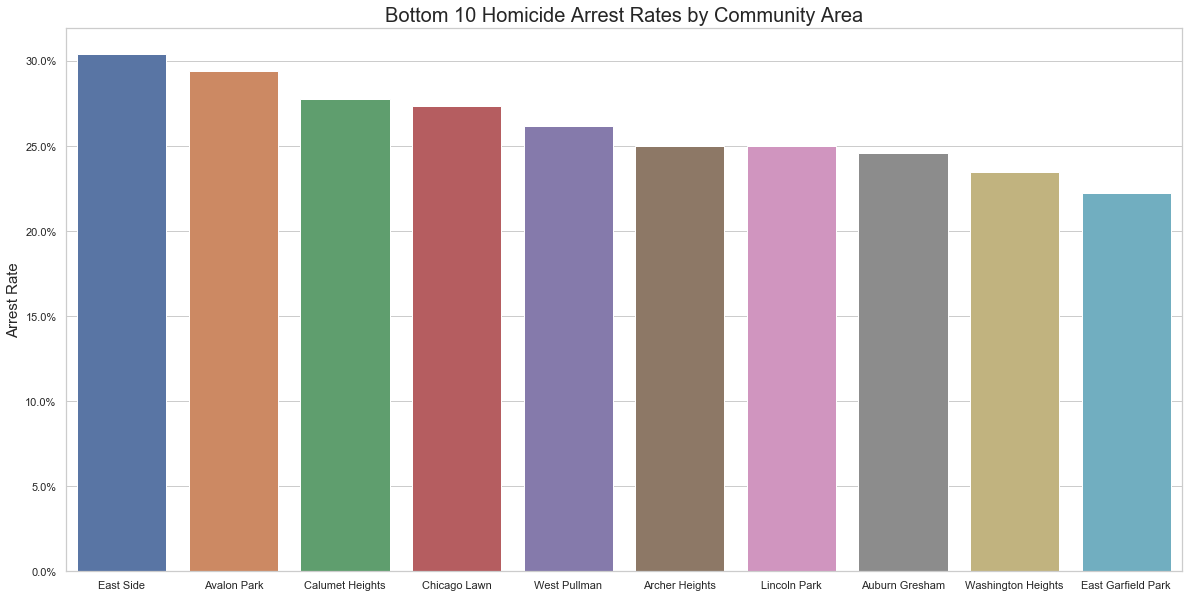

In [18]:
#plotting the homicide arrest rates by community area
plot_crime(comm_area_hom_arrests.iloc[-10:,:], x_col="Community Area", y_col="Arrest Rate", 
           title="Bottom 10 Homicide Arrest Rates by Community Area", y_format='{x:,.1f}%')

<a id="arrests_type">

## Arrest Rates by Type of Crime
From looking at the top and bottom arrest rates by type of crime, we can see that less serious crimes like Obscenity and Gambling have high arrest rates, while heinous crimes like Human Trafficking and Kidnapping have very low arrest rates. While I don't have the data to support this, I believe this is due to the difficulty of catching criminals committing the more serious crimes and finding enough evidence to bring them to court.  
  
Because of the wide range between the top and bottom arrest rates, I believe the type of crime will be a valuable feature in predicting the arrest rate for new crimes. 

In [19]:
#grouping all crimes by community area
type_arrests = crimes.groupby(['Primary Type'])['Arrest'].mean().sort_values(ascending=False).reset_index()
type_arrests.columns = ["Type", "Arrest Rate"]

#converting Arrest Rate column to percentage
type_arrests['Arrest Rate'] *= 100

type_arrests.head(10)

,Type,Arrest Rate
0,Public Indecency,100.000000
1,Gambling,99.841126
2,Prostitution,99.698051
3,Narcotics,99.659483
4,Liquor Law Violation,98.844511
5,Concealed Carry License Violation,96.400000
6,Interference With Public Officer,94.499068
7,Obscenity,78.678038
8,Weapons Violation,76.755448
9,Public Peace Violation,73.831971


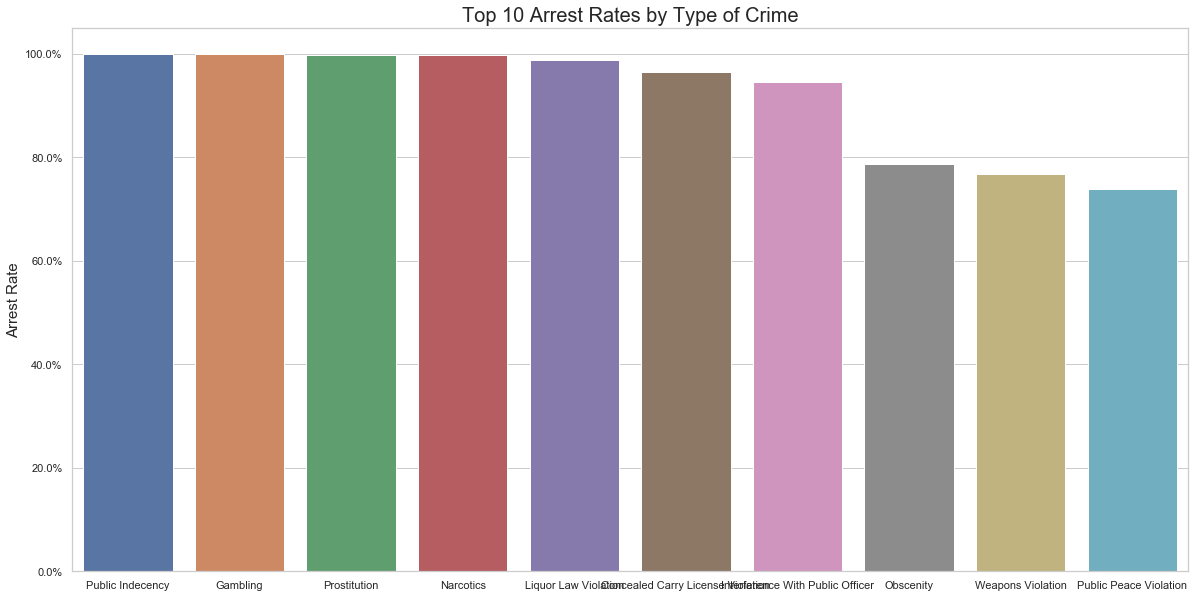

In [20]:
#plotting the arrest rates by community area
plot_crime(type_arrests.iloc[:10,:], x_col="Type", y_col="Arrest Rate", 
           title="Top 10 Arrest Rates by Type of Crime", y_format='{x:,.1f}%')

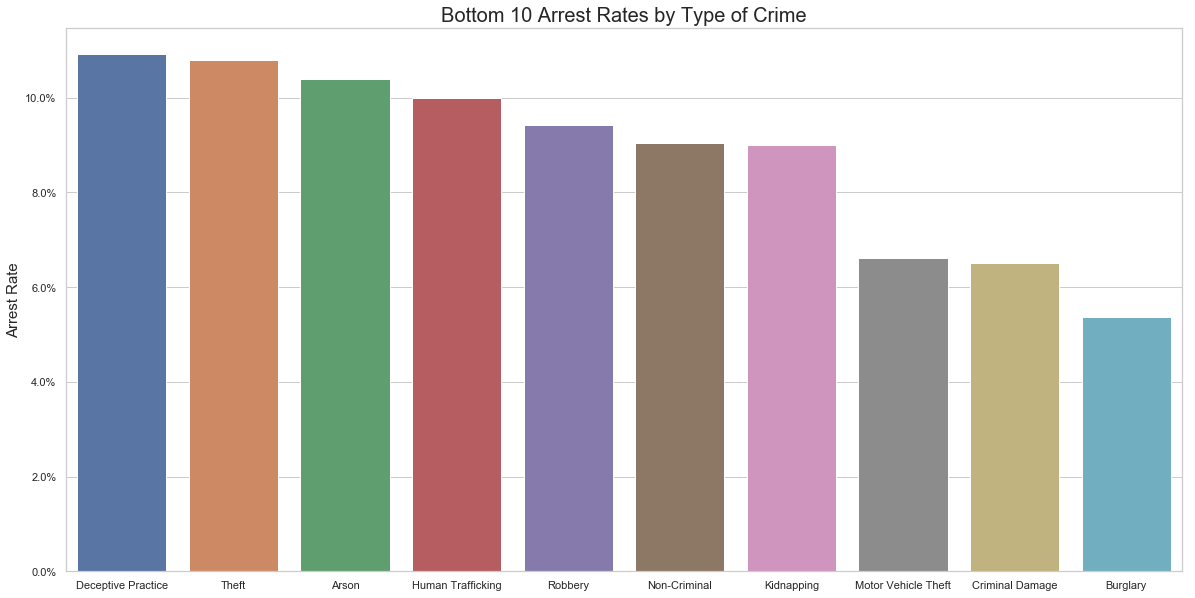

In [21]:
#plotting the arrest rates by community area
plot_crime(type_arrests.iloc[-10:,:], x_col="Type", y_col="Arrest Rate", 
           title="Bottom 10 Arrest Rates by Type of Crime", y_format='{x:,.1f}%')

<a id="arrests_year">

## Arrest Rates by Year

We can see a drop in arrests in 2015 and 2016 before staying relatively flat. My first thought was that the recent lower arrest rates were due to the police having less time compared to older crimes, but with the increase in arrests for crimes committed in 2019 and homicides committed in 2018, I'm am not so sure.  
  
Because there are noticeable changes between the years for arrest rates, I believe this will be a helpful feature for my model.

In [22]:
#grouping all crimes by year
year_arrests = crimes.groupby(['Year'])['Arrest'].mean().sort_values(ascending=False).reset_index()
year_arrests.columns = ["Year", "Arrest Rate"]

#converting Arrest Rate column to percentage
year_arrests['Arrest Rate'] *= 100

year_arrests.head()

,Year,Arrest Rate
0,2014,28.998376
1,2013,28.237864
2,2011,27.421586
3,2010,27.184972
4,2012,27.048216


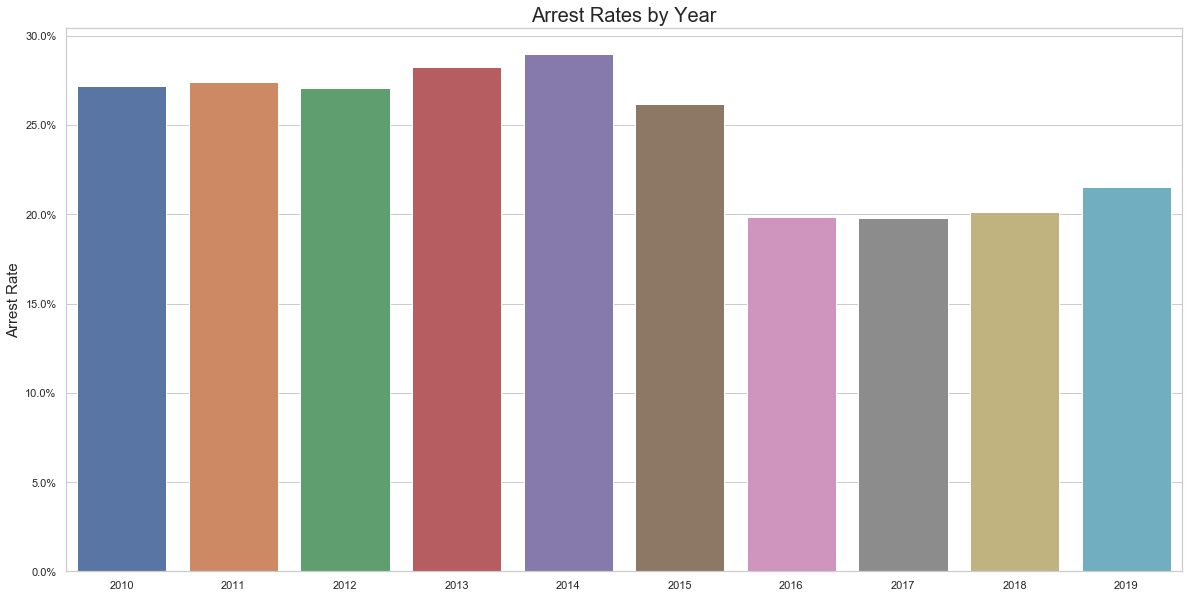

In [23]:
#plotting the arrest rates by year
plot_crime(year_arrests, x_col="Year", y_col="Arrest Rate", 
           title="Arrest Rates by Year", y_format='{x:,.1f}%')

In [24]:
#grouping all crimes by year
year_hom_arrests = crimes[crimes['Primary Type'] == 'Homicide'].groupby(['Year'])['Arrest'].mean().sort_values(ascending=False).reset_index()
year_hom_arrests.columns = ["Year", "Arrest Rate"]

#converting Arrest Rate column to percentage
year_hom_arrests['Arrest Rate'] *= 100

year_hom_arrests.head()

,Year,Arrest Rate
0,2010,46.347032
1,2012,43.980583
2,2014,43.661972
3,2013,43.589744
4,2011,43.150685


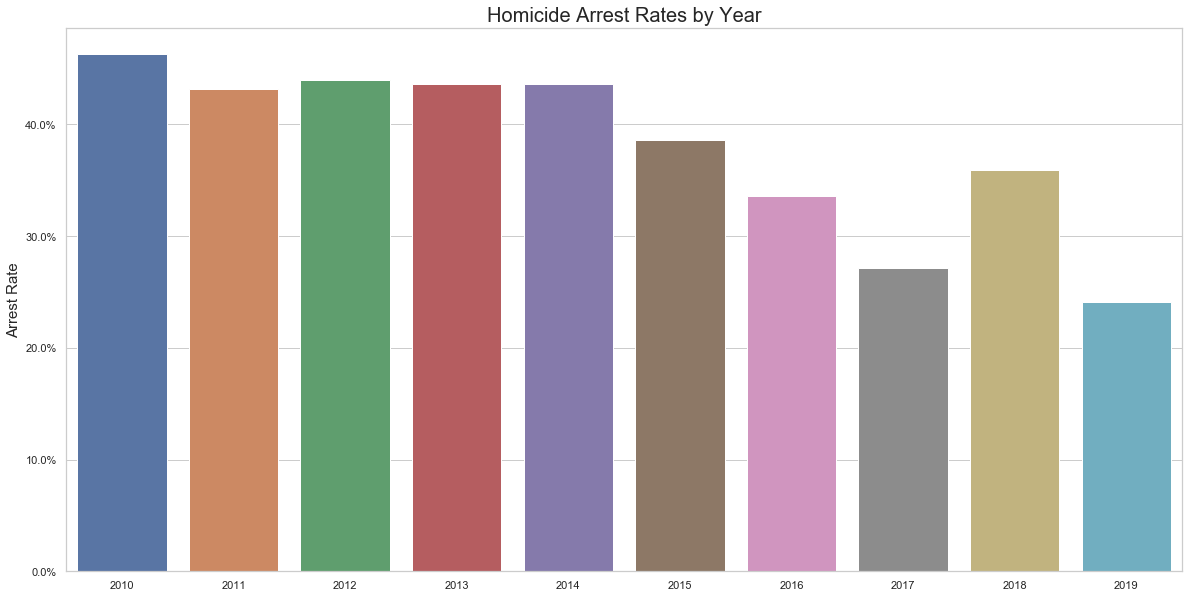

In [25]:
#plotting the arrest rates by community area
plot_crime(year_hom_arrests, x_col="Year", y_col="Arrest Rate", 
           title="Homicide Arrest Rates by Year", y_format='{x:,.1f}%')

<a id="arrests_month">

## Arrest Rates by Month

While the arrest rates are slightly higher in the beginning of the year, I don't believe this will be a helpful feature for my model.

In [26]:
#grouping all crimes by year
month_arrests = crimes.groupby(['Month'])['Arrest'].mean().sort_values(ascending=False).reset_index()
month_arrests.columns = ["Month", "Arrest Rate"]

#converting Arrest Rate column to percentage
month_arrests['Arrest Rate'] *= 100

month_arrests.head()

,Month,Arrest Rate
0,2,28.433097
1,3,27.391812
2,1,26.513879
3,4,25.838419
4,5,24.999906


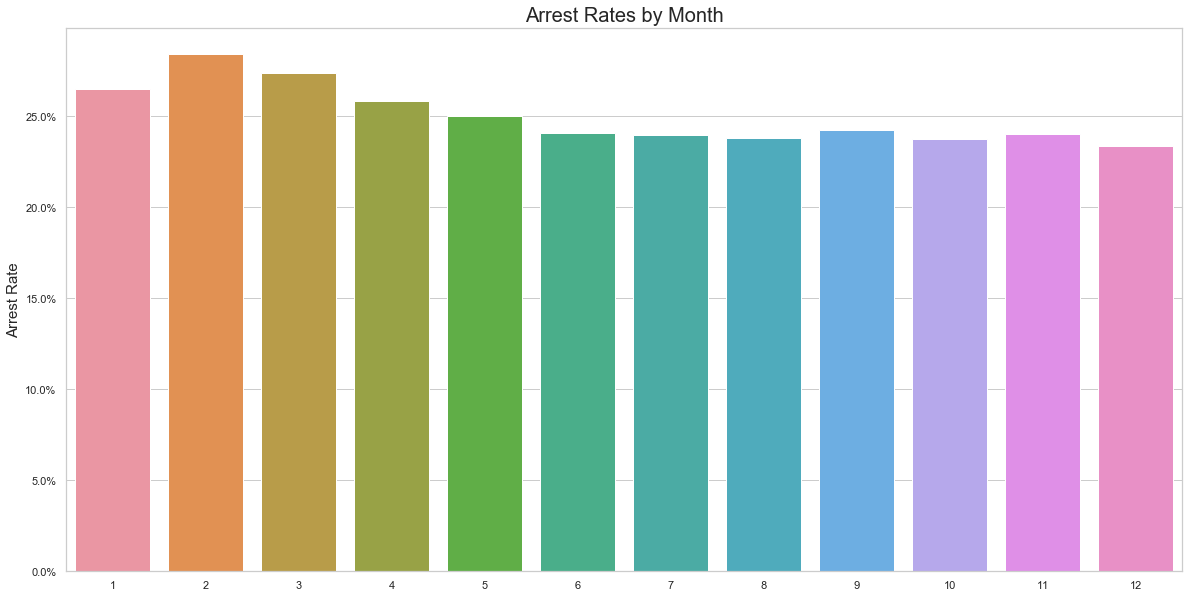

In [27]:
#plotting the arrest rates by year
plot_crime(month_arrests, x_col="Month", y_col="Arrest Rate", 
           title="Arrest Rates by Month", y_format='{x:,.1f}%')

<a id="arrests_domestic">

## Arrest Rates by Domestic vs Non-Domestic Crimes

Because of the relatively small difference between domestic and non-domestic cases, I don't believe this will be a helpful feature in predicting for my model.

In [28]:
print("Arrest Rate for Domest Crimes: {:.2f}%".format(100*crimes[crimes.Domestic == True].Arrest.mean()))
print("Arrest Rate for Non-Domest Crimes: {:.2f}%".format(100*crimes[crimes.Domestic == False].Arrest.mean()))

Arrest Rate for Domest Crimes: 18.94%
Arrest Rate for Non-Domest Crimes: 26.04%


<a id="arrests_season">

## Arrest Rates by Season

Because of the small differences in arrest rates between seasons, I don't believe this will be a helpful feature for my model.

In [29]:
#grouping all crimes by season
season_arrests = crimes.groupby(['Season'])['Arrest'].mean().sort_values(ascending=False).reset_index()
season_arrests.columns = ["Season", "Arrest Rate"]

#converting Arrest Rate column to percentage
season_arrests['Arrest Rate'] *= 100

season_arrests

,Season,Arrest Rate
0,Winter,26.106376
1,Spring,26.041959
2,Fall,24.008597
3,Summer,23.939673


<a id="arrests_time">

## Arrest Rates by Time of Day

Besides crimes committed in the morning, the differences between arrest rates is small. While I am curious as to why crimes committed in the morning have a lower arrest rate, I don't believe this will be a good feature for my model.

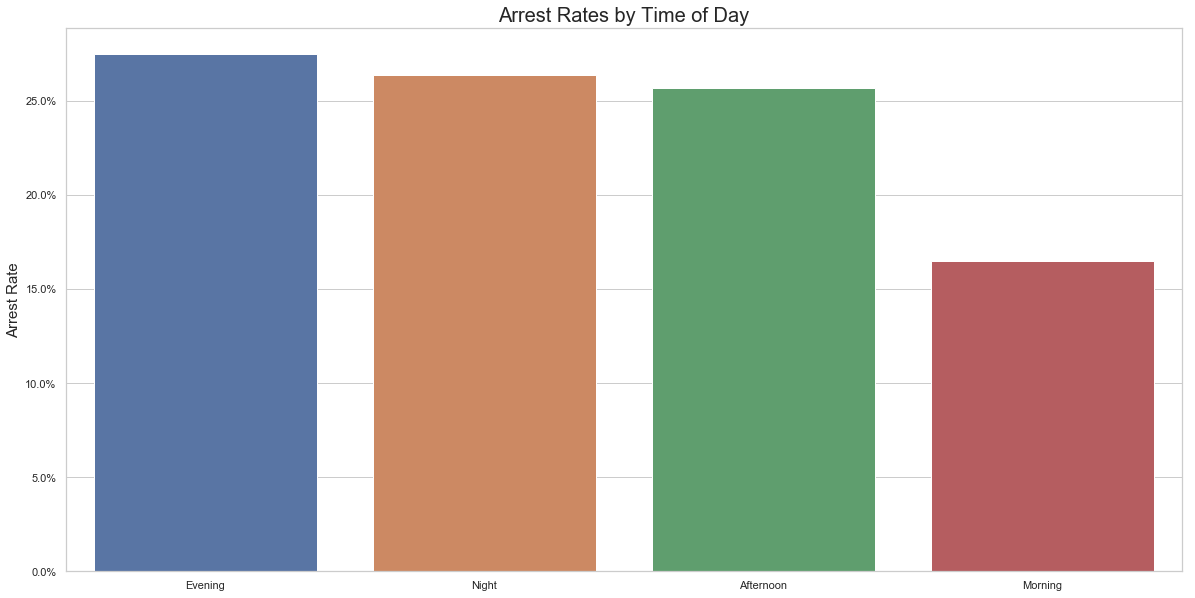

In [30]:
#grouping all crimes by time of day
time_arrests = crimes.groupby(['Time of Day'])['Arrest'].mean().sort_values(ascending=False).reset_index()
time_arrests.columns = ["Time of Day", "Arrest Rate"]

#converting Arrest Rate column to percentage
time_arrests['Arrest Rate'] *= 100

#plotting the arrest rates by time of day
plot_crime(time_arrests, x_col="Time of Day", y_col="Arrest Rate", 
           title="Arrest Rates by Time of Day", y_format='{x:,.1f}%')

<a id="arrests_day">

## Arrest Rates by Day of Week

Because the differences between arrest rates is small, I don't believe this will be a good feature for my model.

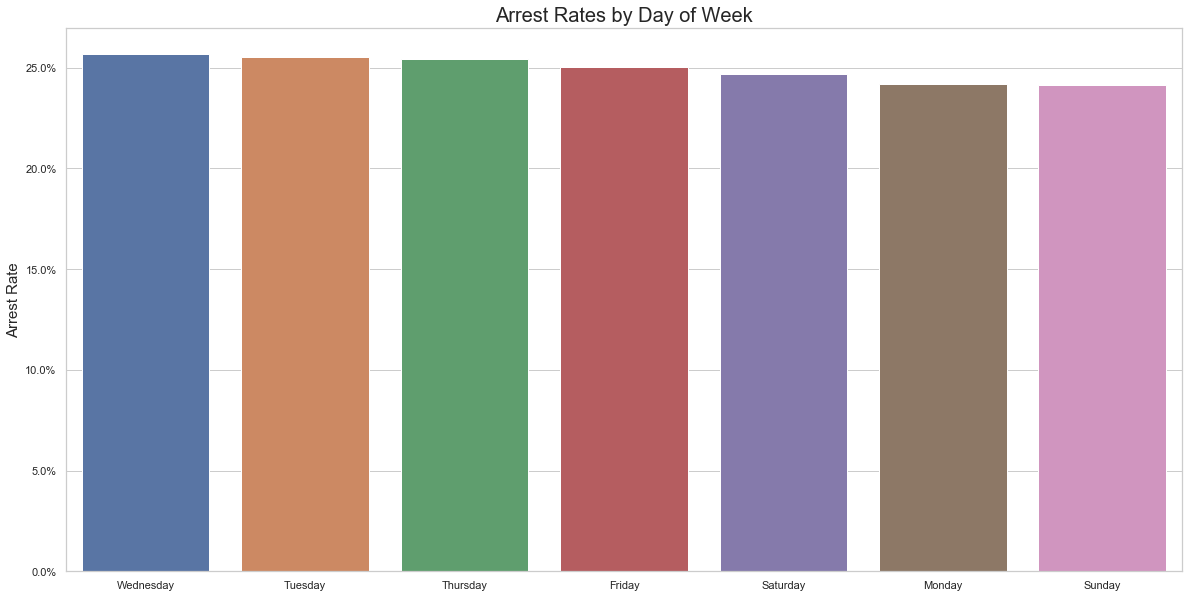

In [31]:
#grouping all crimes by day of week
day_arrests = crimes.groupby(['Day of Week'])['Arrest'].mean().sort_values(ascending=False).reset_index()
day_arrests.columns = ["Day of Week", "Arrest Rate"]

#converting Arrest Rate column to percentage
day_arrests['Arrest Rate'] *= 100

#plotting the arrest rates by day of week
plot_crime(day_arrests, x_col="Day of Week", y_col="Arrest Rate", 
           title="Arrest Rates by Day of Week", y_format='{x:,.1f}%')

<a id="region">

## All Crimes and Homicides by Region

We can see below that the raw counts of crimes for each region can be deceiving. A specific example is the West Side. It has the most crimes by far out of all the regions, but when looking at the crimes per capita (the raw counts divided by the 2010 Census population sizes), we can see that it is actually third, bordering on fourth. 

In [32]:
#grouping all crimes by region
region_counts = crimes.groupby(['Region']).count().iloc[:,0].sort_values(ascending=False).reset_index()
region_counts.columns = ["Region", "Crimes"]

#normalizing counts with 2010 Population
region_counts = region_counts.merge(region_pop, how='inner', on='Region') 
region_counts['Crimes per Capita'] = region_counts['Crimes'] / region_counts['2010 Population']
region_counts.drop(labels=['2010 Population'], axis=1, inplace=True)
region_counts.head()

,Region,Crimes,Crimes per Capita
0,West Side,737020,1.533264
1,Southwest Side,426603,1.095126
2,South Side,390887,1.515536
3,Far Southeast Side,347160,1.544354
4,Far North Side,253233,0.558146


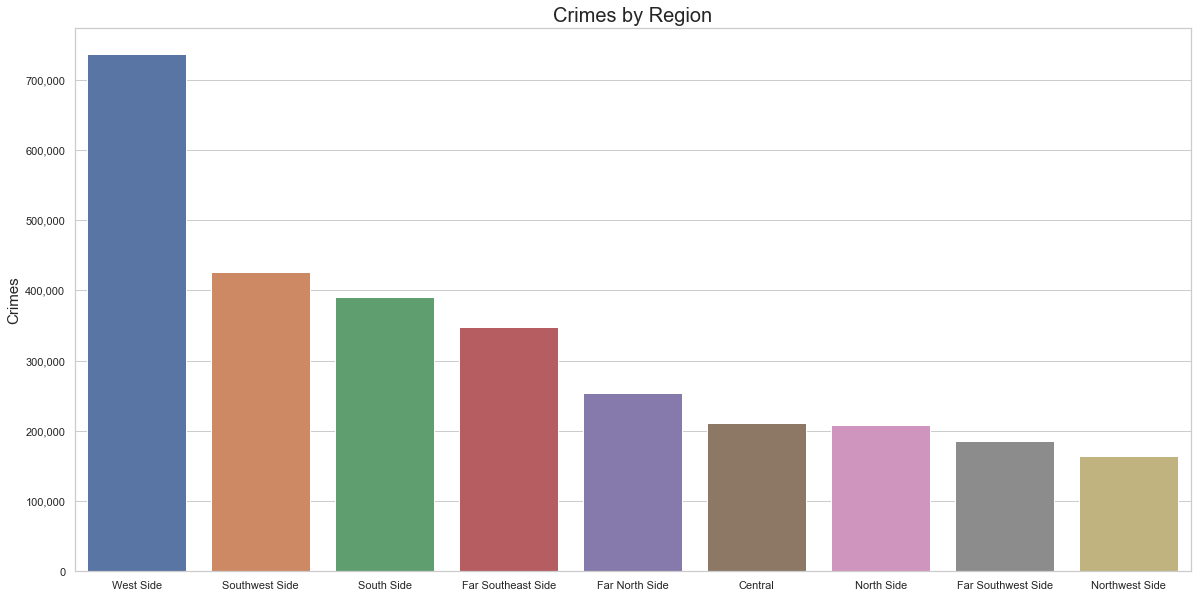

In [33]:
#plotting the crimes by region
plot_crime(region_counts, x_col="Region", y_col="Crimes", title="Crimes by Region")

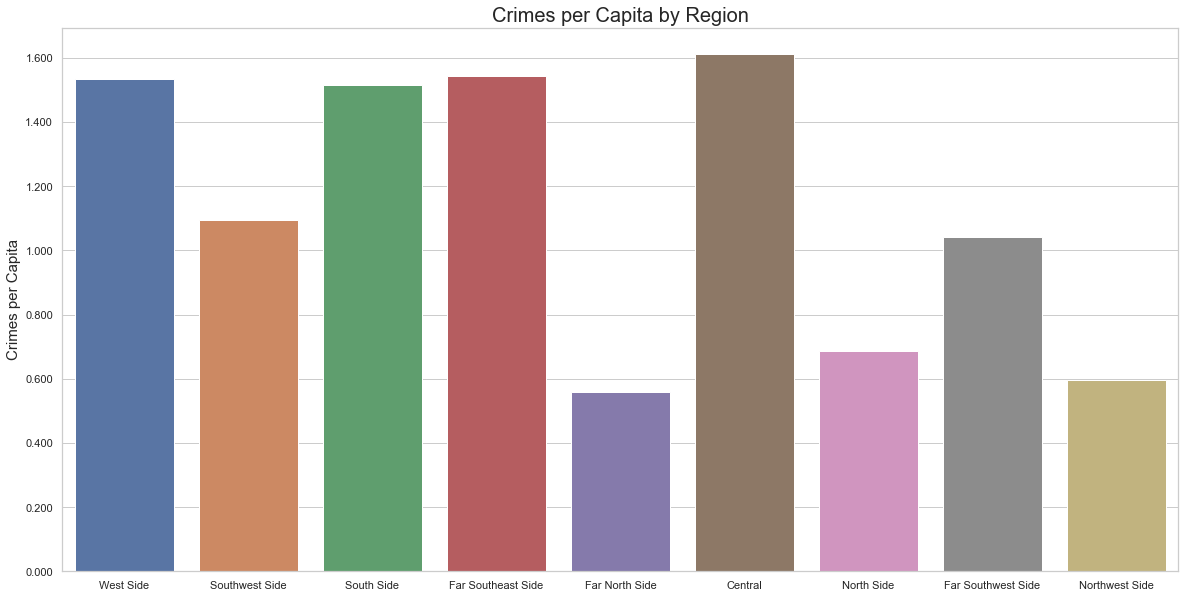

In [34]:
#plotting the crimes by region
plot_crime(region_counts, x_col="Region", y_col="Crimes per Capita", 
           title="Crimes per Capita by Region", y_format='{x:,.3f}')

In [35]:
#grouping the homicides by region
region_hom_counts = crimes[crimes['Primary Type'] == 'Homicide'].groupby(['Region']).count().iloc[:,0].sort_values(ascending=False).reset_index()
region_hom_counts.columns = ["Region", "Homicides"]

#normalizing counts with 2010 Population
region_hom_counts = region_hom_counts.merge(region_pop, how='inner', on='Region') 
region_hom_counts['Homicides per Capita'] = region_hom_counts['Homicides'] / region_hom_counts['2010 Population']
region_hom_counts.drop(labels=['2010 Population'], axis=1, inplace=True)
region_hom_counts.head()

,Region,Homicides,Homicides per Capita
0,West Side,3250,0.006761
1,Southwest Side,2204,0.005658
2,Far Southeast Side,1652,0.007349
3,South Side,1620,0.006281
4,Far Southwest Side,774,0.004349


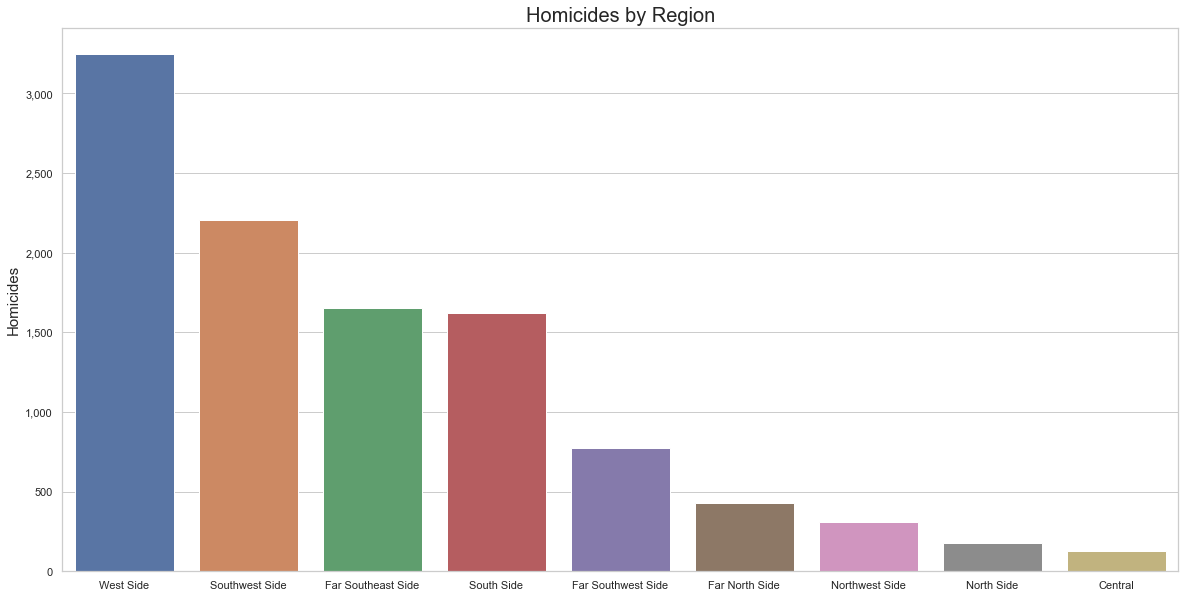

In [36]:
#plotting homicides by region
plot_crime(region_hom_counts, x_col="Region", y_col="Homicides", title="Homicides by Region")

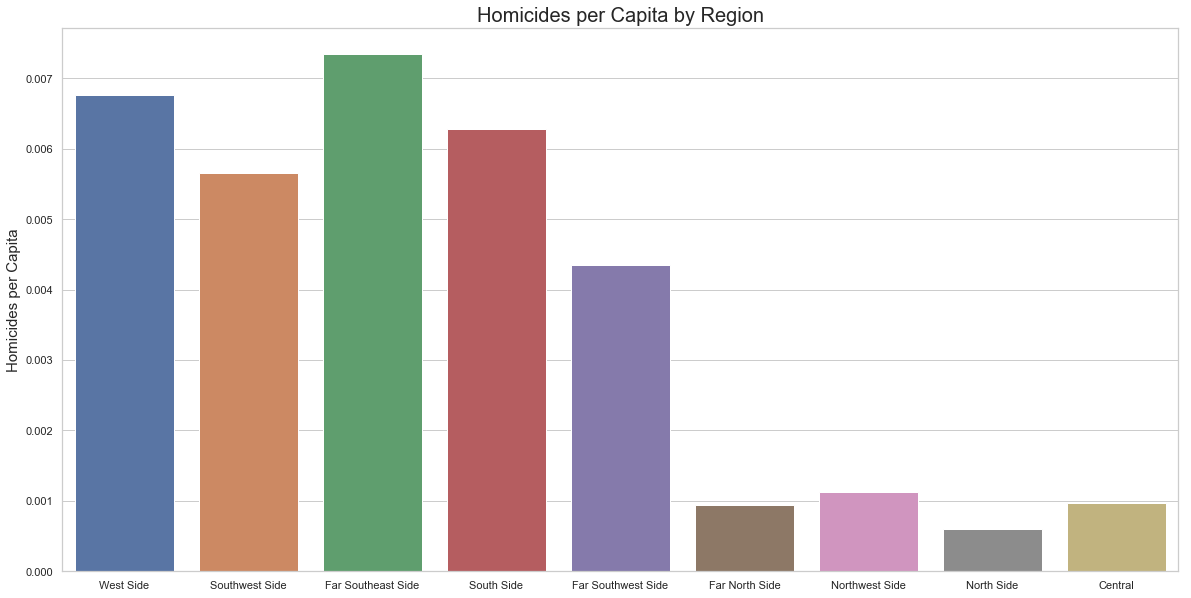

In [37]:
#plotting homicides by region
plot_crime(region_hom_counts, x_col="Region", y_col="Homicides per Capita", 
           title="Homicides per Capita by Region", y_format='{x:,.3f}')

<a id="comm_areas">

## All Crimes and Homicides by Community Area
The plots below support the belief that raw counts of crimes are deceiving. Looking at Fuller Park, it has the 9th lowest amount of crimes but the highest crimes per capita.

In [38]:
#grouping by community area
comm_area_counts = crimes.groupby(['Community Area']).count().iloc[:,0].sort_values(ascending=False).reset_index()
comm_area_counts.columns = ["Community Area", "Crimes"]

#normalizing counts with 2010 Population
comm_area_counts = comm_area_counts.merge(comm_area_pop, how='inner', on='Community Area') 
comm_area_counts['Crimes per Capita'] = comm_area_counts['Crimes'] / comm_area_counts['2010 Population']
comm_area_counts.drop(labels=['2010 Population'], axis=1, inplace=True)
comm_area_counts.head()

,Community Area,Crimes,Region,Crimes per Capita
0,Austin,184662,West Side,1.874475
1,Near North Side,108349,Central,1.346218
2,South Shore,97912,South Side,1.967408
3,Humboldt Park,92893,West Side,1.649291
4,North Lawndale,92808,West Side,2.584317


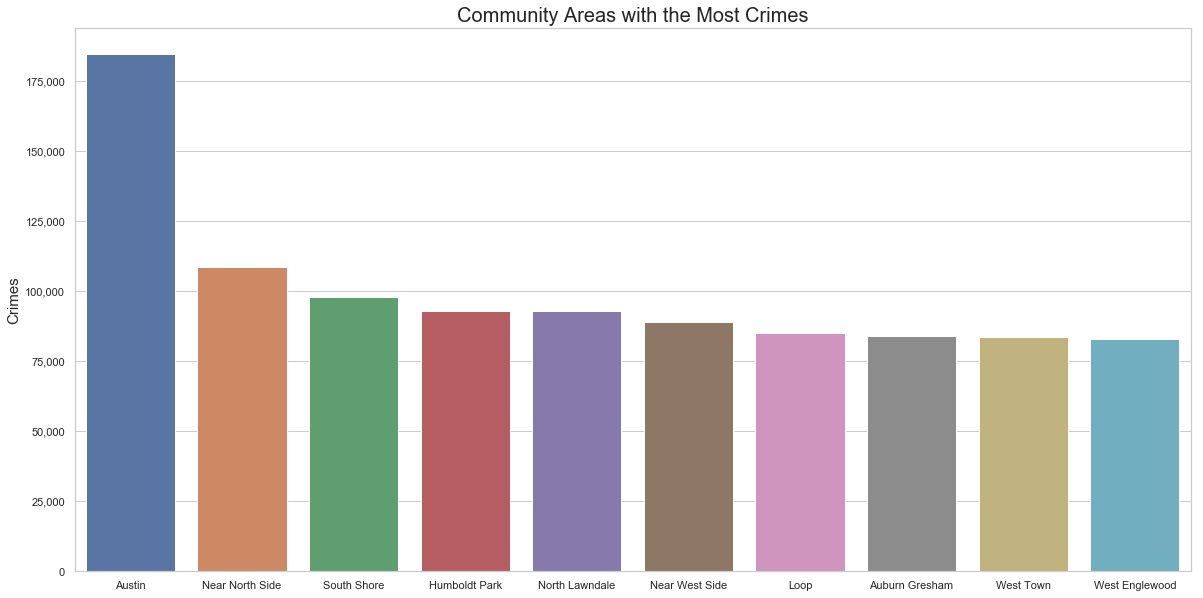

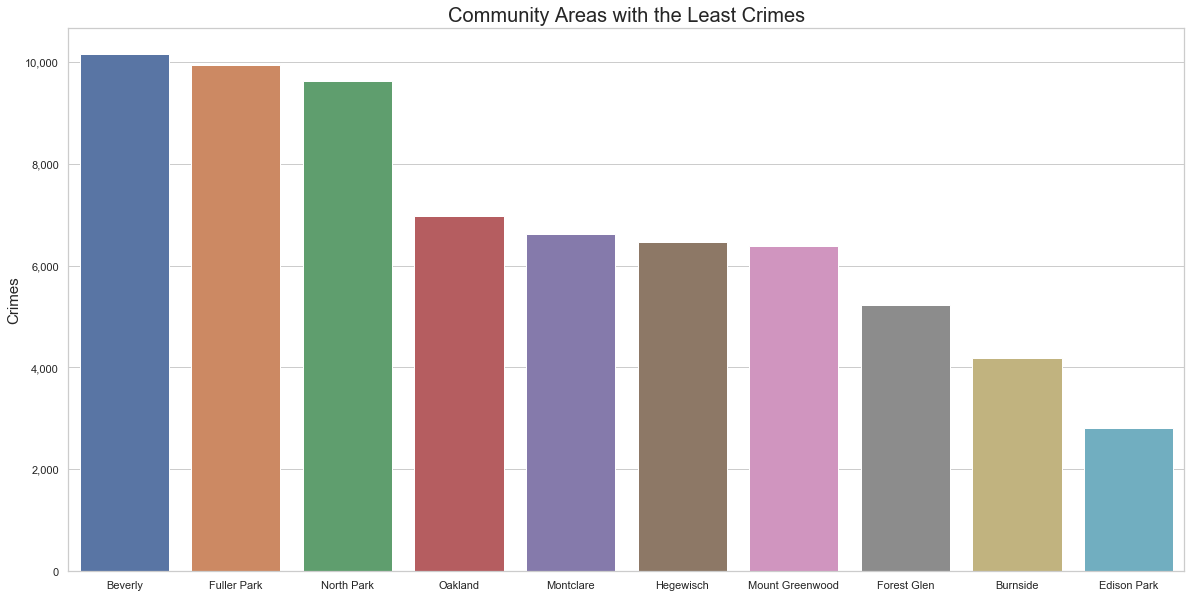

In [39]:
#plotting the Community Areas with the 10 highest counts
plot_crime(comm_area_counts[:10], x_col="Community Area", y_col="Crimes", title="Community Areas with the Most Crimes")

print()

#plotting the Community Areas with the 10 lowest counts
plot_crime(comm_area_counts[-10:], x_col="Community Area", y_col="Crimes", title="Community Areas with the Least Crimes")

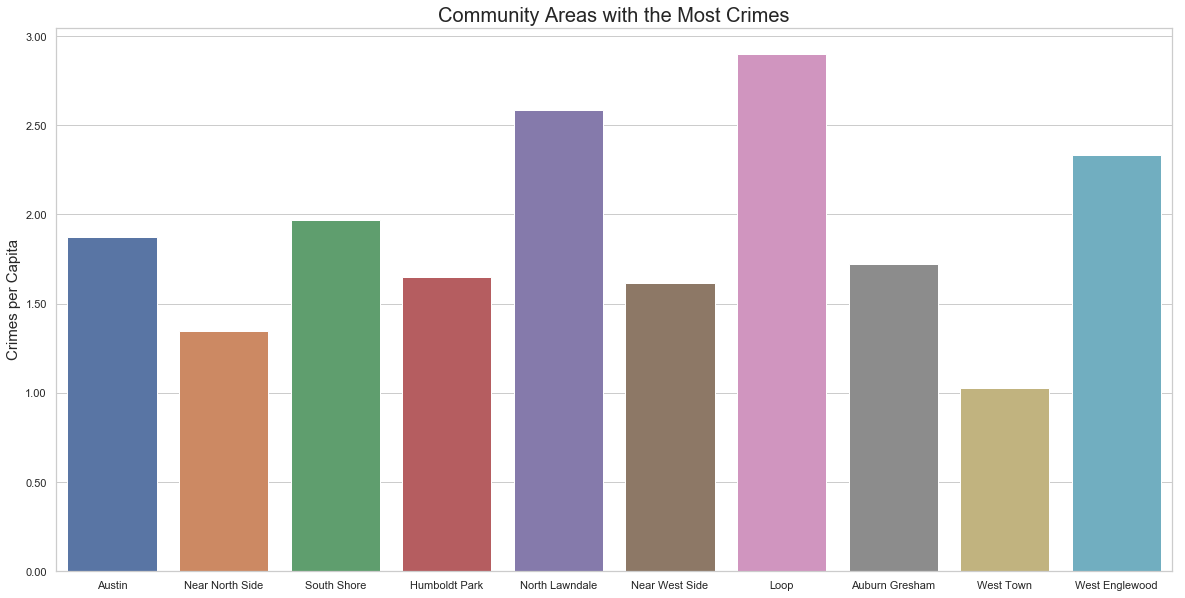

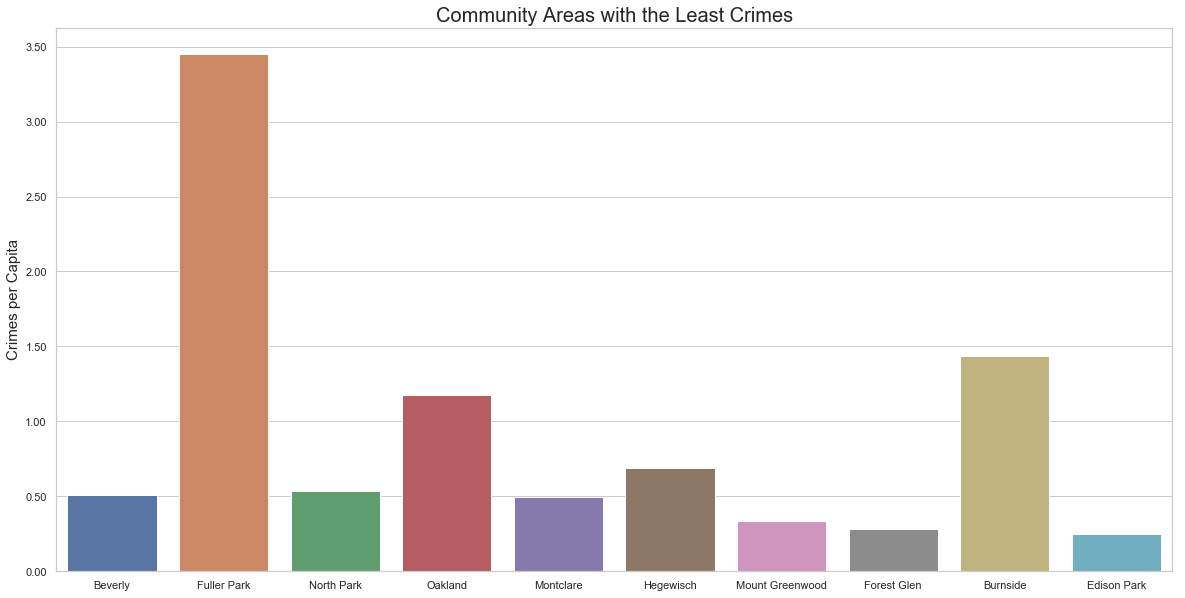

In [40]:
#plotting the Community Areas with the 10 highest counts
plot_crime(comm_area_counts[:10], x_col="Community Area", y_col="Crimes per Capita", 
           title="Community Areas with the Most Crimes", y_format='{x:,.2f}')

print()

#plotting the Community Areas with the 10 lowest counts
plot_crime(comm_area_counts[-10:], x_col="Community Area", y_col="Crimes per Capita", 
           title="Community Areas with the Least Crimes", y_format='{x:,.2f}')

In [41]:
comm_area_counts.iloc[comm_area_counts['Crimes per Capita'].idxmax(),:]

Community Area       Fuller Park
Crimes                      9932
Region                South Side
Crimes per Capita        3.45341
Name: 68, dtype: object

In [42]:
#grouping the homicides by community area
comm_area_hom_counts = crimes[crimes['Primary Type'] == 'Homicide'].groupby(['Community Area']).count().iloc[:,0].sort_values(ascending=False).reset_index()
comm_area_hom_counts.columns = ["Community Area", "Homicides"]

#normalizing counts with 2010 Population
comm_area_hom_counts = comm_area_hom_counts.merge(comm_area_pop, how='inner', on='Community Area') 
comm_area_hom_counts['Homicides per Capita'] = comm_area_hom_counts['Homicides'] / comm_area_hom_counts['2010 Population']
comm_area_hom_counts.drop(labels=['2010 Population'], axis=1, inplace=True)
comm_area_hom_counts.head()

,Community Area,Homicides,Region,Homicides per Capita
0,Austin,964,West Side,0.009785
1,Englewood,506,Southwest Side,0.016507
2,West Englewood,492,Southwest Side,0.013857
3,North Lawndale,474,West Side,0.013199
4,Humboldt Park,466,West Side,0.008274


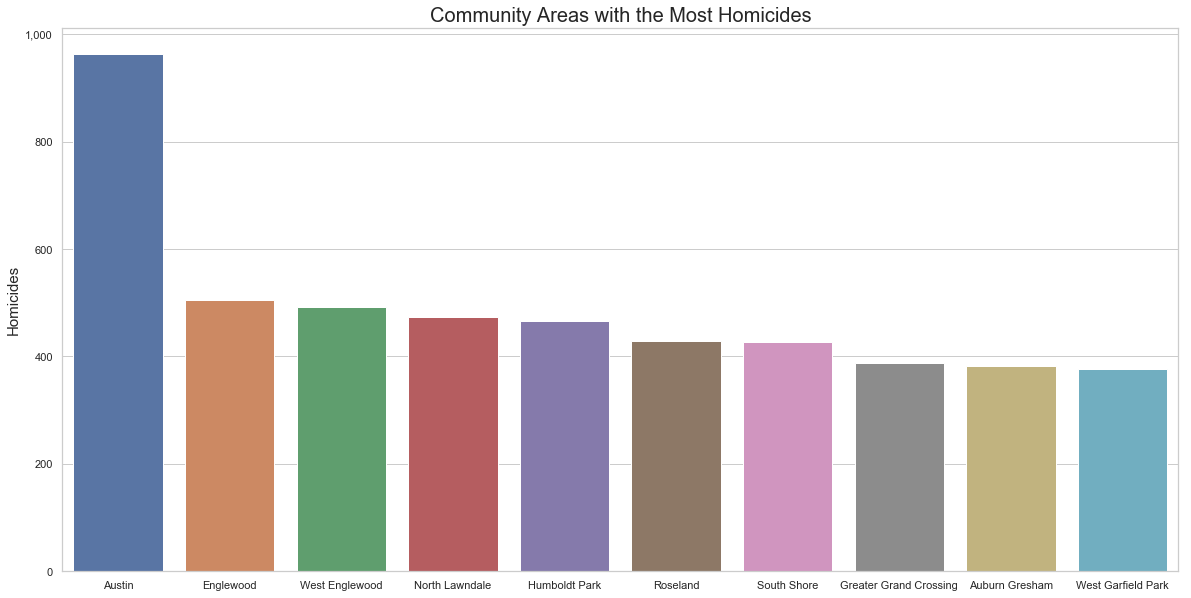

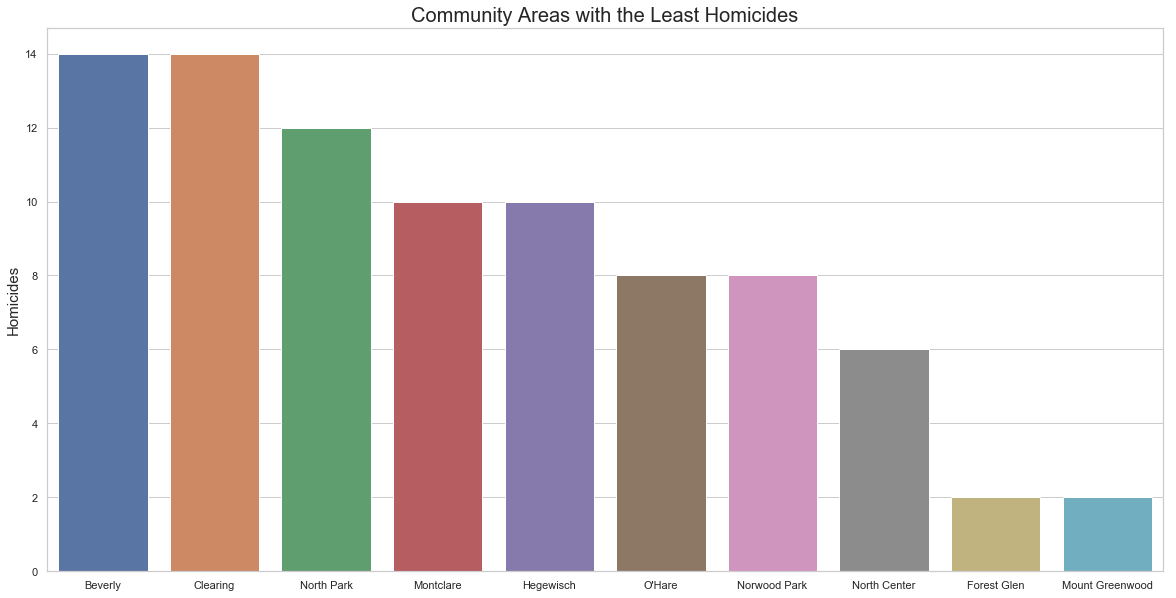

In [43]:
#plotting the community areas with the most homicides
plot_crime(comm_area_hom_counts[:10], x_col="Community Area", y_col="Homicides", 
           title="Community Areas with the Most Homicides")

print()

#plotting the community areas with the least homicides
plot_crime(comm_area_hom_counts[-10:], x_col="Community Area", y_col="Homicides", 
           title="Community Areas with the Least Homicides")

<a id="year">

## All Crimes and Homicides by Year
In the first line graph below, we can see that crimes have been decreasing over time.
  
In the second line graph, we can see a large spike in homicides in 2016 for a few regions, but the counts drop afterwards. 

In [44]:
#grouping by Year, Month, and Region
date_region_counts = crimes.groupby(['Year','Region']).count().iloc[:,0].reset_index()
date_region_counts.columns = ['Year','Region','Crimes']
date_region_counts.sort_values(by=['Year'], ascending=True, inplace=True)

In [45]:
date_region_counts.head()

,Year,Region,Crimes
0,2010,Central,21422
1,2010,Far North Side,32220
2,2010,Far Southeast Side,43093
3,2010,Far Southwest Side,24075
4,2010,North Side,27215


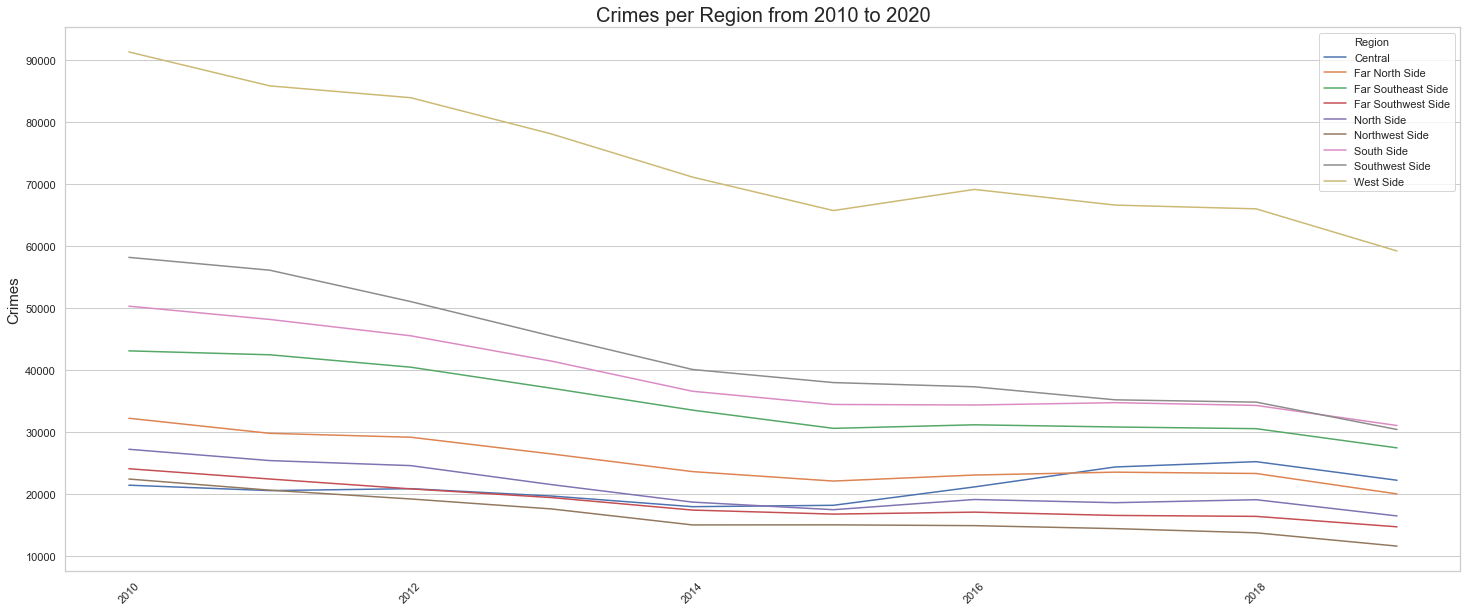

In [46]:
fig,ax = plt.subplots(figsize=(25,10))
ax = sns.lineplot(data=date_region_counts, x="Year", y="Crimes", hue="Region", sort=False)

plt.title("Crimes per Region from 2010 to 2020", fontsize=20)
plt.xticks(rotation=45)
ax.xaxis.grid(False)
ax.yaxis.grid(True)
plt.xlabel(None)
plt.ylabel("Crimes", fontsize=15)
plt.show()

In [47]:
#grouping by Year, Month, and Region
date_region_hom_counts = crimes[crimes['Primary Type'] == 'Homicide'].groupby(['Year','Region']).count().iloc[:,0].reset_index()
date_region_hom_counts.columns = ['Year','Region','Homicides']
date_region_hom_counts.sort_values(by=['Year'], ascending=True, inplace=True)

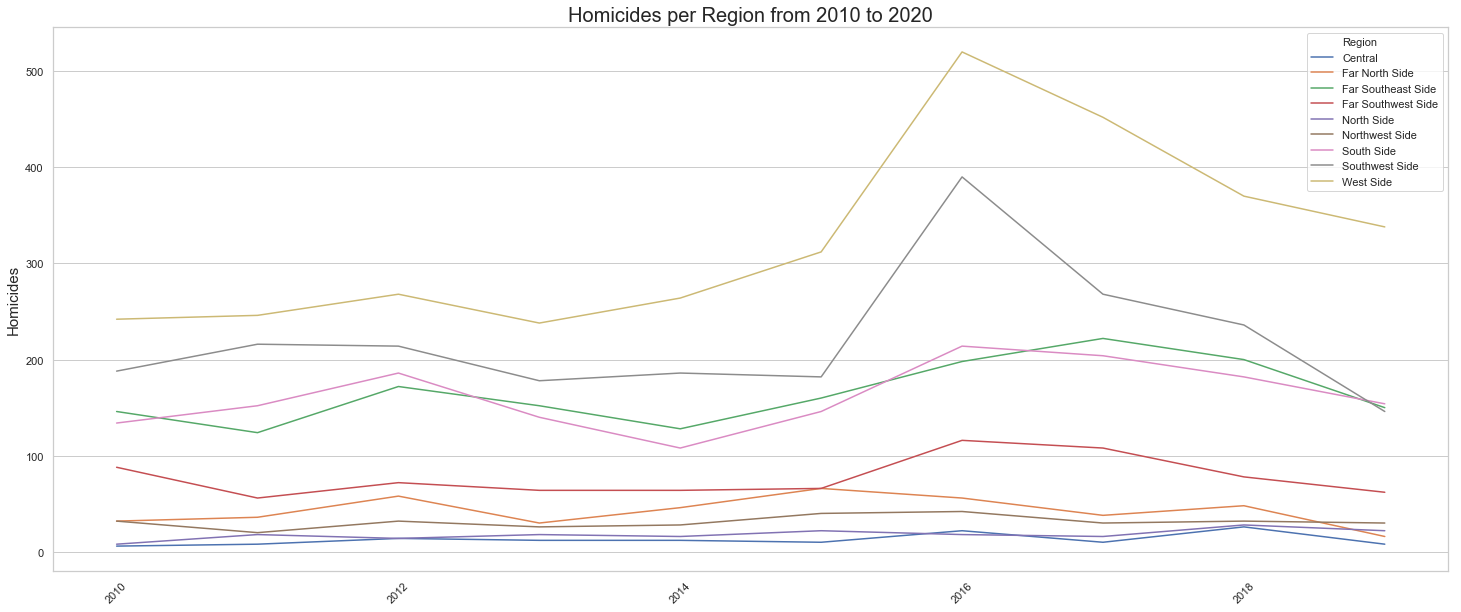

In [48]:
fig,ax = plt.subplots(figsize=(25,10))
ax = sns.lineplot(data=date_region_hom_counts, x="Year", y="Homicides", hue="Region", sort=False)

plt.title("Homicides per Region from 2010 to 2020", fontsize=20)
plt.xticks(rotation=45)
ax.xaxis.grid(False)
ax.yaxis.grid(True)
plt.xlabel(None)
plt.ylabel("Homicides", fontsize=15)
plt.show()

<a id="time">

## All Crimes and Homicides by Time of Day
Confirming what I believed, most homicides occur at night. However, the most crimes occur during the afternoon, which surprised me. 

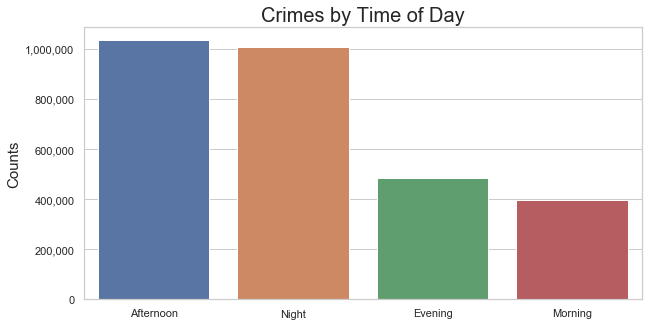

In [49]:
#grouping the crimes by time of day
time_counts = crimes.groupby(['Time of Day']).count().iloc[:,0].sort_values(ascending=False).reset_index()
time_counts.columns = ["Time of Day", "Counts"]

#plotting crimes by time of day
plot_crime(time_counts, x_col="Time of Day", y_col="Counts", title="Crimes by Time of Day", fig_size=(10,5))

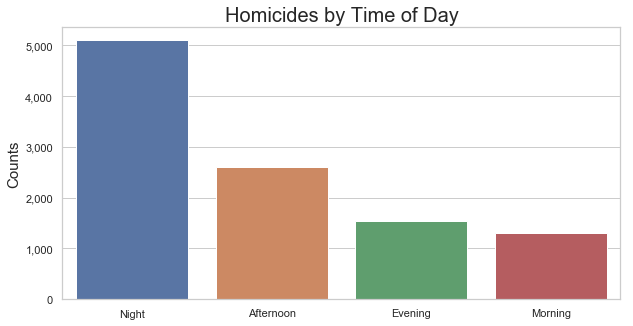

In [50]:
#grouping the homicides by time of day
time_hom_counts = crimes[crimes['Primary Type'] == 'Homicide'].groupby(['Time of Day']).count().iloc[:,0].sort_values(ascending=False).reset_index()
time_hom_counts.columns = ["Time of Day", "Counts"]

#plotting homicides by time of day
plot_crime(time_hom_counts, x_col="Time of Day", y_col="Counts", title="Homicides by Time of Day", fig_size=(10,5))

<a id="season">

## All Crimes and Homicides by Season
As expected, there are more crimes and homicides during the summer than all other seasons. My assumption, although I am unable to confirm this, is this has to do with the warmer weather leading to more people being outside, and therefore, more vunerable to crime.

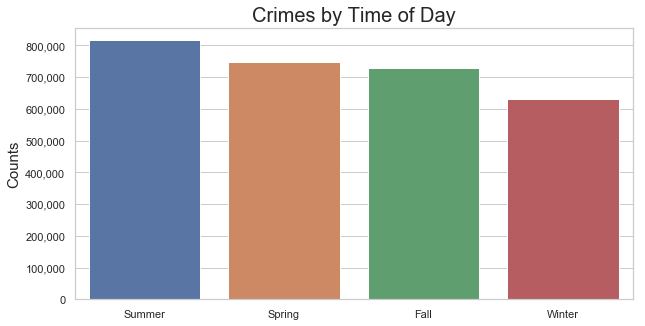

In [51]:
#grouping the crimes by season
season_counts = crimes.groupby(['Season']).count().iloc[:,0].sort_values(ascending=False).reset_index()
season_counts.columns = ["Season", "Counts"]

#plotting crimes by season
plot_crime(season_counts, x_col="Season", y_col="Counts", title="Crimes by Time of Day", fig_size=(10,5))

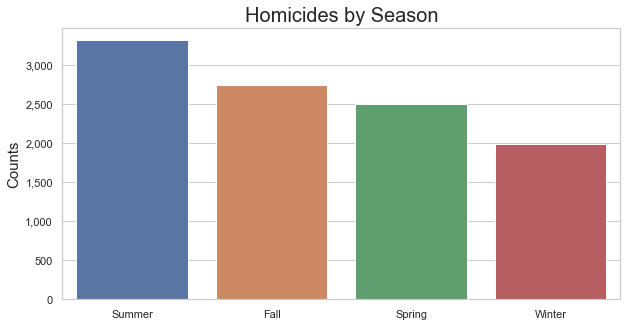

In [52]:
#grouping the homicides by season
season_hom_counts = crimes[crimes['Primary Type'] == 'Homicide'].groupby(['Season']).count().iloc[:,0].sort_values(ascending=False).reset_index()
season_hom_counts.columns = ["Season", "Counts"]

#plotting homicides by season
plot_crime(season_hom_counts, x_col="Season", y_col="Counts", title="Homicides by Season", fig_size=(10,5))